In [126]:
df = pd.read_csv('2019_Polo_Towers.csv')
df = df[:365]
df['occ_rate'] = df['Sum of Occ'].str.replace('%', '').astype(int) / 100
df['ADR (USD)'] = df['Sum of ADR'].str.replace('$', '').astype(int)
df['Rental_RevPar (USD)'] = df['Sum of Rental RevPar'].str.replace('$', '').astype(int)
df['Row Labels'] =  pd.to_datetime(df['Row Labels'])
df = df.rename(columns={'Row Labels': 'Date'})

According to this [Github issue](https://github.com/facebook/prophet/issues/783), If we want to capture yearly seasonality, then we need at least a year of data, if we only care about weekly seasonality then a couple weeks would suffice. I don't think the hotels need us to forecast for the next week, because they know better from reservations on their books. And I still want to keep some data for testing purpose. So, I will use first 10 months data for training, and last two months data for testing.

In [127]:
df.head()

,Date,Sum of ADR,Sum of Occ,Sum of Rental RevPar,occ_rate,ADR (USD),Rental_RevPar (USD)
0,2019-01-01,$108,86%,$32,0.86,108,32
1,2019-01-02,$92,79%,$26,0.79,92,26
2,2019-01-03,$87,77%,$27,0.77,87,27
3,2019-01-04,$105,70%,$30,0.70,105,30
4,2019-01-05,$102,64%,$29,0.64,102,29


In [128]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

plt.style.use('fivethirtyeight')

In [129]:
df = df[['Date', 'occ_rate']]
df.set_index('Date', inplace=True)

In [130]:
split_date = '2019-11-01'
train = df.loc[df.index < split_date].copy()
test = df.loc[df.index >= split_date].copy()

In [48]:
pd.plotting.register_matplotlib_converters()

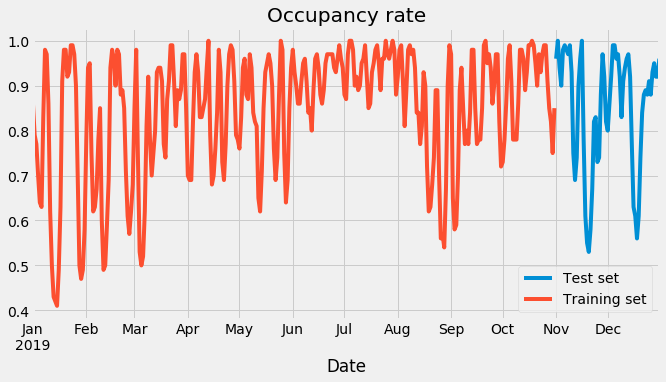

In [132]:
test \
.rename(columns={'occ_rate': 'Test set'}) \
.join(train.rename(columns={'occ_rate': 'Training set'}),
      how='outer') \
.plot(figsize=(10,5), title='Occupancy rate')
plt.show();

In [133]:
train.reset_index() \
.rename(columns={'Date':'ds',
                     'occ_rate':'y'})

,ds,y
0,2019-01-01,0.86
1,2019-01-02,0.79
2,2019-01-03,0.77
3,2019-01-04,0.70
4,2019-01-05,0.64
...,...,...
299,2019-10-27,0.91
300,2019-10-28,0.85
301,2019-10-29,0.82
302,2019-10-30,0.75


### Start with a simple model

In [135]:
# Setup and train model and fit
model_simple = Prophet(interval_width=0.95)
model_simple.fit(train.reset_index() \
              .rename(columns={'Date':'ds',
                               'occ_rate':'y'}))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [136]:
forecast_simple = model_simple.predict(df=test.reset_index() \
                                   .rename(columns={'Date':'ds'}))

In [137]:
forecast_simple.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-11-01,0.883824,0.747892,1.191869,0.883813,0.883829,0.078290,0.078290,0.078290,0.078290,0.078290,0.078290,0.0,0.0,0.0,0.962114
1,2019-11-02,0.883786,0.750775,1.196249,0.883749,0.883817,0.093632,0.093632,0.093632,0.093632,0.093632,0.093632,0.0,0.0,0.0,0.977418
2,2019-11-03,0.883749,0.690699,1.126964,0.883670,0.883819,0.010359,0.010359,0.010359,0.010359,0.010359,0.010359,0.0,0.0,0.0,0.894108
3,2019-11-04,0.883712,0.607181,1.038821,0.883586,0.883845,-0.072214,-0.072214,-0.072214,-0.072214,-0.072214,-0.072214,0.0,0.0,0.0,0.811498
4,2019-11-05,0.883674,0.615762,1.037869,0.883491,0.883862,-0.063803,-0.063803,-0.063803,-0.063803,-0.063803,-0.063803,0.0,0.0,0.0,0.819871


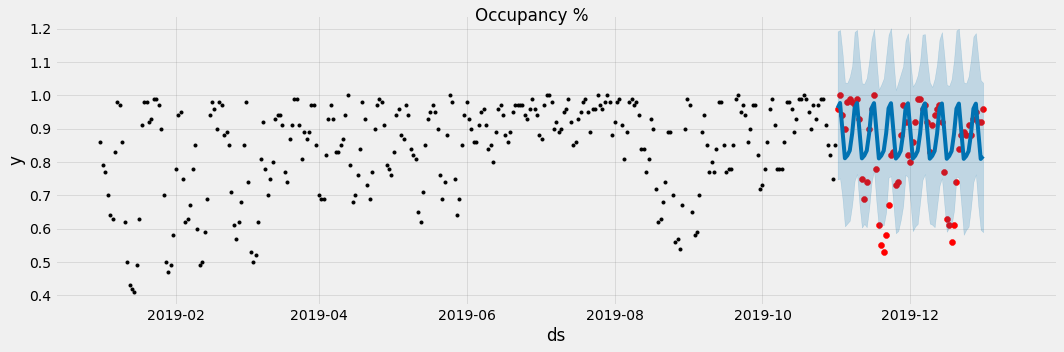

In [146]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['occ_rate'], color='r')
fig = model_simple.plot(forecast_simple, ax=ax)
plot = plt.suptitle('Occupancy %');

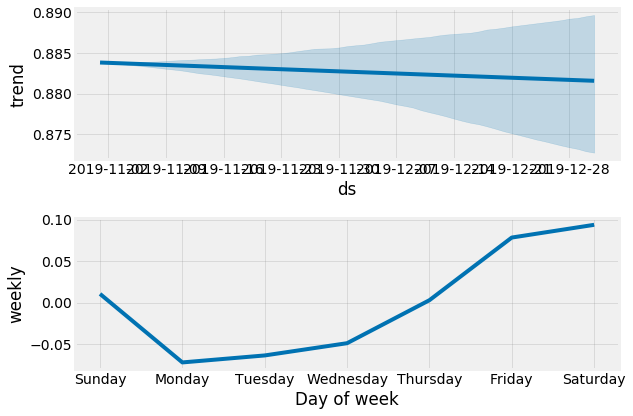

In [145]:
# Plot the components of the model
model_simple.plot_components(forecast_simple);

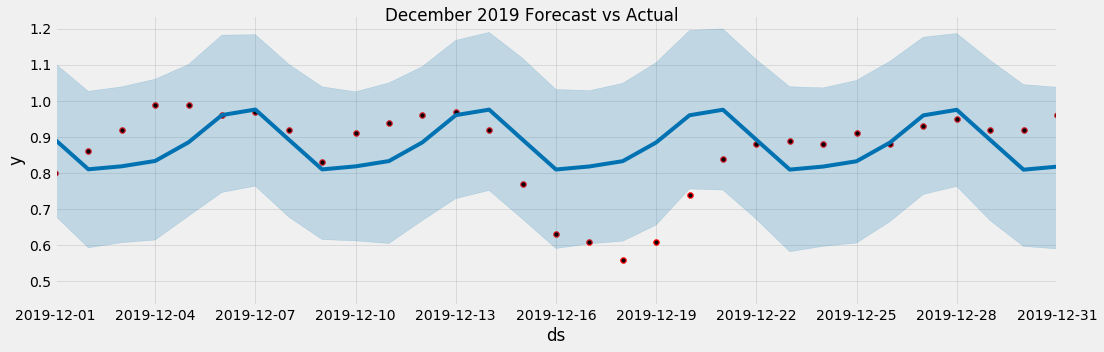

In [149]:
# Plot the forecast vs. the actual
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['occ_rate'], color='r')
fig = model.plot(forecast_simple, ax=ax)
ax.set_xbound(lower='2019-12-01',
              upper='2019-12-31')
plot = plt.suptitle('December 2019 Forecast vs Actual')

In [156]:
print('The MSE is {}'. format(mean_squared_error(y_true=test['occ_rate'], y_pred=forecast_simple['yhat'])))

The MSE is 0.016715338827504696


In [152]:
print('The MAE is {}'. format(mean_absolute_error(y_true=test['occ_rate'], y_pred=forecast_simple['yhat'])))

The MAE is 0.09879151191670789


### Adding public holiday as an indicator, remove a couple of outliers

In [153]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()
train_holidays = cal.holidays(start=train.index.min(),
                              end=train.index.max())
test_holidays = cal.holidays(start=test.index.min(),
                             end=test.index.max())

In [155]:
df.head(2)

,occ_rate
Date,
2019-01-01,0.86
2019-01-02,0.79


In [158]:
# Create a dataframe with holiday, ds columns
df['date'] = df.index.date
df['is_holiday'] = df.date.isin([d.date() for d in cal.holidays()])
holiday_df = df.loc[df['is_holiday']] \
    .reset_index() \
    .rename(columns={'date':'ds'})
holiday_df['holiday'] = 'USFederalHoliday'

In [160]:
holiday_df.drop(['occ_rate','Date','is_holiday'], axis=1, inplace=True)
holiday_df

,ds,holiday
0,2019-01-01,USFederalHoliday
1,2019-01-21,USFederalHoliday
2,2019-02-18,USFederalHoliday
3,2019-05-27,USFederalHoliday
4,2019-07-04,USFederalHoliday
5,2019-09-02,USFederalHoliday
6,2019-10-14,USFederalHoliday
7,2019-11-11,USFederalHoliday
8,2019-11-28,USFederalHoliday
9,2019-12-25,USFederalHoliday


In [162]:
holiday_df['ds'] = pd.to_datetime(holiday_df['ds'])

In [174]:
train = train.reset_index().rename(columns={'Date':'ds', 'occ_rate':'y'})

In [176]:
train.loc[(train['ds'] >= '2019-01-13') & (train['ds'] <= '2019-01-15'), 'y'] = None
train.loc[(train['ds'] >= '2019-01-28') & (train['ds'] <= '2019-01-30'), 'y'] = None
train.loc[(train['ds'] >= '2019-02-11') & (train['ds'] <= '2019-02-12'), 'y'] = None

In [177]:
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [178]:
forecast_with_holidays = \
    model_with_holidays.predict(df=test.reset_index() \
                                    .rename(columns={'Date':'ds'}))

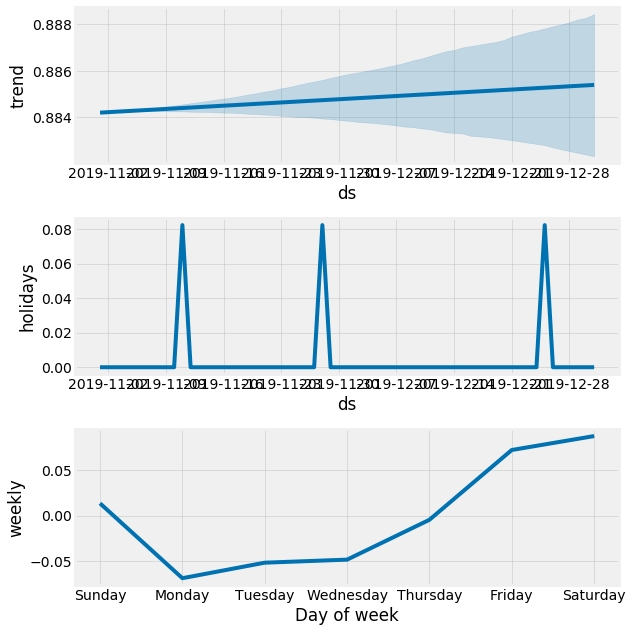

In [180]:
model_with_holidays.plot_components(forecast_with_holidays);

In [182]:
print('The MSE is {}'. format(mean_squared_error(y_true=test['occ_rate'], y_pred=forecast_with_holidays['yhat'])))

The MSE is 0.016819355931023253


In [183]:
print('The MAE is {}'. format(mean_absolute_error(y_true=test['occ_rate'],
                   y_pred=test_fcst_with_holidays['yhat'])))

The MAE is 0.09906962401211249


Compare with the simple model, the error increased a little. I think it is because the first 10 months holiday and outliers do not give valuable information to the last 2 months. If we use 2019 one-year (at least) to forecast 2010, the holiday and outliers should be useful. Regardless, I will use 2019 data to forecast 2020 using this model.

In [188]:
df.reset_index(inplace=True)
df = df[['Date', 'occ_rate']]
df = df.rename(columns = {'Date': 'ds', 'occ_rate': 'y'})

In [190]:
df.loc[(df['ds'] >= '2019-01-13') & (df['ds'] <= '2019-01-15'), 'y'] = None
df.loc[(df['ds'] >= '2019-01-28') & (df['ds'] <= '2019-01-30'), 'y'] = None
df.loc[(df['ds'] >= '2019-02-11') & (df['ds'] <= '2019-02-12'), 'y'] = None

In [191]:
model = Prophet(holidays=holiday_df)
model.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1440x360 with 0 Axes>

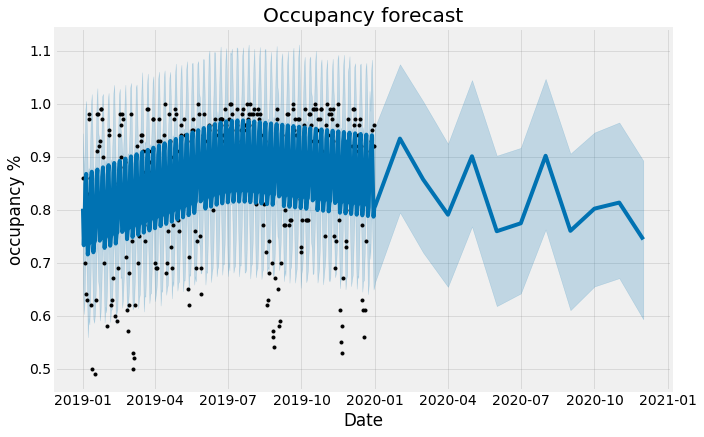

In [199]:
forecast = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(forecast)
plt.figure(figsize=(20, 5))
model.plot(forecast, xlabel = 'Date', ylabel = 'occupancy %')
plt.title('Occupancy forecast');

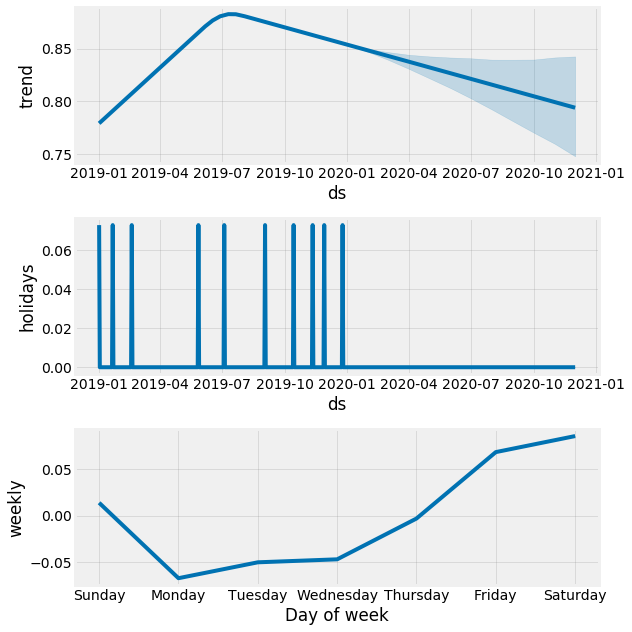

In [201]:
model.plot_components(forecast);

In [198]:
metric_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
error = mean_squared_error(metric_df.y, metric_df.yhat)
print('The MSE is {}'. format(error))

The MSE is 0.011724841859149317


In [115]:
df = pd.read_csv('2019_Polo_Towers.csv')
df = df[:365]
df['occ_rate'] = df['Sum of Occ'].str.replace('%', '').astype(int) / 100
df['ADR (USD)'] = df['Sum of ADR'].str.replace('$', '').astype(int)
df['Rental_RevPar (USD)'] = df['Sum of Rental RevPar'].str.replace('$', '').astype(int)

df['Row Labels'] =  pd.to_datetime(df['Row Labels'])
df = df.rename(columns={'Row Labels': 'Date'})

In [117]:
df = df[['Date', 'occ_rate']]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 720x360 with 0 Axes>

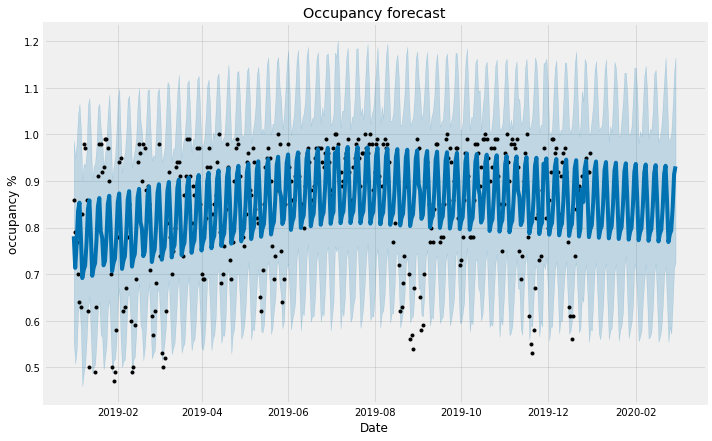

In [119]:
df = df.rename(columns = {'Date': 'ds', 'occ_rate': 'y'})
#occ['hurricane_season'] = occ['ds'].apply(is_hurricane_season)
#occ['not_hurricane_season'] = ~occ['ds'].apply(is_hurricane_season)
model = Prophet(interval_width=0.95, holidays=holiday_df)
# Remove outliers in Jan
df.loc[(df['ds'] >= '2019-01-13') & (df['ds'] <= '2019-01-15'), 'y'] = None
# Add hurricane
#model.add_seasonality(name='hurricane_season', period=365, fourier_order=10, condition_name='hurricane_season')
#model.add_seasonality(name='not_hurricane_season', period=365, fourier_order=10, condition_name='not_hurricane_season')
model.fit(df)
forecast = model.make_future_dataframe(periods=60, freq='D')
# forecast['hurricane_season'] = forecast['ds'].apply(is_hurricane_season)
# forecast['not_hurricane_season'] = ~forecast['ds'].apply(is_hurricane_season)

forecast = model.predict(forecast)
plt.figure(figsize=(10, 5))
model.plot(forecast, xlabel = 'Date', ylabel = 'occupancy %')
plt.title('Occupancy forecast');

In [122]:
metric_df = forecast.set_index('ds')[['yhat']].join(df.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
error = mean_squared_error(metric_df.y, metric_df.yhat)
print('The MSE is {}'. format(error))

The MSE is 0.012306735525578625


In [124]:
metric_df

,ds,yhat,y
0,2019-01-01,0.781308,0.86
1,2019-01-02,0.713505,0.79
2,2019-01-03,0.763061,0.77
3,2019-01-04,0.835541,0.70
4,2019-01-05,0.853502,0.64
...,...,...,...
360,2019-12-27,0.926168,0.93
361,2019-12-28,0.943235,0.95
362,2019-12-29,0.870796,0.92
363,2019-12-30,0.779498,0.92


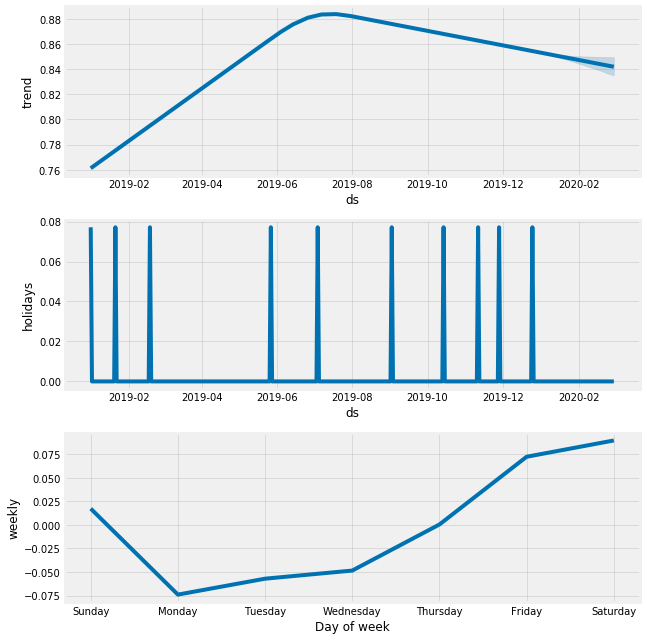

In [125]:
model.plot_components(forecast);